In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum


In [2]:
# This block is the same as 1_dataset.ipynb

dataset = "/afs/cern.ch/work/m/mgarciam/public/mlpf_250723/pf_tree_1.root"


class Args:
    def __init__(self):
        self.data_train = [dataset]
        self.data_val = [dataset]
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

In [3]:
iterator = iter(train_data)
g, gt = next(iterator)
g
g.ndata['particle_number'].unique()
gt
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)
g, y = next(iterator)
y.shape
y

=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


tensor([[ 2.4762e-01, -7.5051e-01,  6.1271e-01,  9.6900e-01,  2.3703e-01,
          9.3957e-01,  2.1120e+03],
        [ 6.6059e-02, -8.1978e-01,  5.6886e-01,  2.3858e+01,  2.3858e+01,
         -7.2873e-03, -2.1100e+02],
        [-2.0235e-01, -6.8251e-01,  7.0231e-01,  1.3559e+01,  1.3527e+01,
          9.3827e-01,  2.2120e+03]])

In [4]:
g

Graph(num_nodes=523, num_edges=3661,
      ndata_schemes={'h': Scheme(shape=(9,), dtype=torch.float32), 'pos_hits': Scheme(shape=(3,), dtype=torch.float32), 'pos_hits_norm': Scheme(shape=(3,), dtype=torch.float32), 'hit_type': Scheme(shape=(4,), dtype=torch.int64), 'p_hits': Scheme(shape=(1,), dtype=torch.float32), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

In [9]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()[true_idx]  #[hit_idx]
    where_e_zero = hit_energies == 0
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    y_energy = y[:, 3]
    y_pid = y[:, -1].to(torch.long)
    energy_from_showers = energy_from_showers[1:]
    #print(energy_from_showers.shape, y_energy.shape)
    assert len(energy_from_showers) > 0
    if return_pid_dict:
        pids = y_pid.unique().long()
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    return (energy_from_showers / y_energy).tolist()


In [6]:
all_ratios = {}

def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(range(500)):
    g, y = next(iterator)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios = upd_dict(all_ratios, ratios)
    #TODOs tmrw: check particle number dist., how many are we throwing away

  0%|▏                                                                                                                      | 1/500 [00:00<02:42,  3.06it/s]

torch.Size([4]) torch.Size([4])


  0%|▍                                                                                                                      | 2/500 [00:00<02:16,  3.64it/s]

torch.Size([2]) torch.Size([2])


  1%|▋                                                                                                                      | 3/500 [00:00<02:23,  3.46it/s]

torch.Size([2]) torch.Size([2])


  1%|▉                                                                                                                      | 4/500 [00:01<02:48,  2.94it/s]

torch.Size([5]) torch.Size([5])


  1%|█▍                                                                                                                     | 6/500 [00:01<02:04,  3.96it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])


  1%|█▋                                                                                                                     | 7/500 [00:02<02:21,  3.49it/s]

torch.Size([4]) torch.Size([4])


  2%|█▉                                                                                                                     | 8/500 [00:02<02:25,  3.39it/s]

torch.Size([3]) torch.Size([3])


  2%|██▏                                                                                                                    | 9/500 [00:02<02:29,  3.28it/s]

torch.Size([2]) torch.Size([2])


  2%|██▎                                                                                                                   | 10/500 [00:02<02:16,  3.59it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


  2%|██▊                                                                                                                   | 12/500 [00:03<01:48,  4.49it/s]

torch.Size([3]) torch.Size([3])


  3%|███                                                                                                                   | 13/500 [00:03<02:20,  3.46it/s]

torch.Size([2]) torch.Size([2])


  3%|███▎                                                                                                                  | 14/500 [00:04<02:43,  2.97it/s]

torch.Size([2]) torch.Size([2])


  3%|███▌                                                                                                                  | 15/500 [00:04<02:29,  3.25it/s]

torch.Size([4]) torch.Size([4])


  3%|███▊                                                                                                                  | 16/500 [00:05<03:11,  2.52it/s]

torch.Size([5]) torch.Size([5])


  3%|████                                                                                                                  | 17/500 [00:05<02:53,  2.78it/s]

torch.Size([2]) torch.Size([2])


  4%|████▏                                                                                                                 | 18/500 [00:05<02:57,  2.72it/s]

torch.Size([4]) torch.Size([4])


  4%|████▍                                                                                                                 | 19/500 [00:05<02:49,  2.84it/s]

torch.Size([5]) torch.Size([5])


  4%|████▉                                                                                                                 | 21/500 [00:06<02:21,  3.39it/s]

torch.Size([2]) torch.Size([2])
torch.Size([3]) torch.Size([3])


  4%|█████▏                                                                                                                | 22/500 [00:06<02:00,  3.96it/s]

torch.Size([4]) torch.Size([4])
torch.Size([1]) torch.Size([1])


  5%|█████▋                                                                                                                | 24/500 [00:06<01:28,  5.40it/s]

torch.Size([2]) torch.Size([2])


  5%|█████▉                                                                                                                | 25/500 [00:07<01:53,  4.19it/s]

torch.Size([3]) torch.Size([3])


  5%|██████▏                                                                                                               | 26/500 [00:07<02:02,  3.86it/s]

torch.Size([2]) torch.Size([2])


  5%|██████▎                                                                                                               | 27/500 [00:08<02:32,  3.10it/s]

torch.Size([3]) torch.Size([3])


  6%|██████▌                                                                                                               | 28/500 [00:08<02:47,  2.82it/s]

torch.Size([3]) torch.Size([3])


  6%|██████▊                                                                                                               | 29/500 [00:08<02:35,  3.03it/s]

torch.Size([3]) torch.Size([3])


  6%|███████                                                                                                               | 30/500 [00:09<02:38,  2.96it/s]

torch.Size([1]) torch.Size([1])


  6%|███████▌                                                                                                              | 32/500 [00:09<02:08,  3.64it/s]

torch.Size([5]) torch.Size([5])
torch.Size([3]) torch.Size([3])


  7%|███████▊                                                                                                              | 33/500 [00:09<02:15,  3.44it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


  7%|████████▎                                                                                                             | 35/500 [00:10<01:45,  4.43it/s]

torch.Size([2]) torch.Size([2])


  7%|████████▍                                                                                                             | 36/500 [00:10<01:53,  4.10it/s]

torch.Size([5]) torch.Size([5])


  7%|████████▋                                                                                                             | 37/500 [00:10<02:18,  3.35it/s]

torch.Size([4]) torch.Size([4])


  8%|████████▉                                                                                                             | 38/500 [00:11<02:12,  3.49it/s]

torch.Size([1]) torch.Size([1])


  8%|█████████▏                                                                                                            | 39/500 [00:11<02:07,  3.61it/s]

torch.Size([1]) torch.Size([1])


  8%|█████████▍                                                                                                            | 40/500 [00:11<02:14,  3.42it/s]

torch.Size([2]) torch.Size([2])


  8%|█████████▉                                                                                                            | 42/500 [00:12<02:18,  3.30it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


  9%|██████████▏                                                                                                           | 43/500 [00:12<01:52,  4.08it/s]

torch.Size([3]) torch.Size([3])


  9%|██████████▊                                                                                                           | 46/500 [00:13<01:24,  5.37it/s]

torch.Size([5]) torch.Size([5])
torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


  9%|███████████                                                                                                           | 47/500 [00:13<01:21,  5.56it/s]

torch.Size([1]) torch.Size([1])


 10%|███████████▎                                                                                                          | 48/500 [00:13<01:36,  4.67it/s]

torch.Size([1]) torch.Size([1])


 10%|███████████▌                                                                                                          | 49/500 [00:13<01:43,  4.37it/s]

torch.Size([2]) torch.Size([2])


 10%|███████████▊                                                                                                          | 50/500 [00:14<02:18,  3.24it/s]

torch.Size([5]) torch.Size([5])
torch.Size([1]) torch.Size([1])


 10%|████████████▎                                                                                                         | 52/500 [00:14<02:10,  3.43it/s]

torch.Size([3]) torch.Size([3])


 11%|████████████▌                                                                                                         | 53/500 [00:15<02:15,  3.30it/s]

torch.Size([4]) torch.Size([4])


 11%|████████████▋                                                                                                         | 54/500 [00:15<02:23,  3.11it/s]

torch.Size([5]) torch.Size([5])


 11%|█████████████▏                                                                                                        | 56/500 [00:16<01:56,  3.80it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 12%|█████████████▋                                                                                                        | 58/500 [00:16<01:29,  4.95it/s]

torch.Size([1]) torch.Size([1])
torch.Size([3]) torch.Size([3])


 12%|█████████████▉                                                                                                        | 59/500 [00:16<01:29,  4.92it/s]

torch.Size([2]) torch.Size([2])


 12%|██████████████▏                                                                                                       | 60/500 [00:16<01:48,  4.05it/s]

torch.Size([3]) torch.Size([3])


 12%|██████████████▍                                                                                                       | 61/500 [00:17<02:11,  3.34it/s]

torch.Size([1]) torch.Size([1])


 12%|██████████████▋                                                                                                       | 62/500 [00:17<02:09,  3.39it/s]

torch.Size([2]) torch.Size([2])


 13%|██████████████▊                                                                                                       | 63/500 [00:18<02:25,  3.00it/s]

torch.Size([4]) torch.Size([4])


 13%|███████████████                                                                                                       | 64/500 [00:18<02:16,  3.20it/s]

torch.Size([4]) torch.Size([4])


 13%|███████████████▌                                                                                                      | 66/500 [00:18<01:53,  3.81it/s]

torch.Size([2]) torch.Size([2])
torch.Size([1]) torch.Size([1])


 14%|████████████████▎                                                                                                     | 69/500 [00:19<01:16,  5.65it/s]

torch.Size([5]) torch.Size([5])
torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 14%|████████████████▊                                                                                                     | 71/500 [00:19<01:25,  5.02it/s]

torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


 14%|████████████████▉                                                                                                     | 72/500 [00:20<02:08,  3.34it/s]

torch.Size([4]) torch.Size([4])


 15%|█████████████████▏                                                                                                    | 73/500 [00:20<02:00,  3.53it/s]

torch.Size([2]) torch.Size([2])


 15%|█████████████████▍                                                                                                    | 74/500 [00:20<01:58,  3.58it/s]

torch.Size([2]) torch.Size([2])


 15%|█████████████████▋                                                                                                    | 75/500 [00:20<01:55,  3.67it/s]

torch.Size([2]) torch.Size([2])


 15%|█████████████████▉                                                                                                    | 76/500 [00:21<02:20,  3.03it/s]

torch.Size([5]) torch.Size([5])


 15%|██████████████████▏                                                                                                   | 77/500 [00:21<02:12,  3.20it/s]

torch.Size([3]) torch.Size([3])


 16%|██████████████████▍                                                                                                   | 78/500 [00:22<02:19,  3.02it/s]

torch.Size([2]) torch.Size([2])


 16%|██████████████████▋                                                                                                   | 79/500 [00:22<02:36,  2.70it/s]

torch.Size([2]) torch.Size([2])


 16%|███████████████████                                                                                                   | 81/500 [00:23<02:04,  3.36it/s]

torch.Size([4]) torch.Size([4])
torch.Size([1]) torch.Size([1])


 16%|███████████████████▎                                                                                                  | 82/500 [00:23<01:55,  3.62it/s]

torch.Size([4]) torch.Size([4])


 17%|███████████████████▊                                                                                                  | 84/500 [00:23<02:03,  3.37it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])


 17%|████████████████████                                                                                                  | 85/500 [00:24<01:47,  3.87it/s]

torch.Size([1]) torch.Size([1])


 17%|████████████████████▎                                                                                                 | 86/500 [00:24<01:40,  4.12it/s]

torch.Size([1]) torch.Size([1])


 17%|████████████████████▌                                                                                                 | 87/500 [00:24<01:57,  3.53it/s]

torch.Size([2]) torch.Size([2])


 18%|████████████████████▊                                                                                                 | 88/500 [00:25<02:34,  2.66it/s]

torch.Size([5]) torch.Size([5])


 18%|█████████████████████                                                                                                 | 89/500 [00:25<02:27,  2.79it/s]

torch.Size([2]) torch.Size([2])


 18%|█████████████████████▍                                                                                                | 91/500 [00:26<01:49,  3.75it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 18%|█████████████████████▋                                                                                                | 92/500 [00:26<01:37,  4.18it/s]

torch.Size([4]) torch.Size([4])


 19%|█████████████████████▉                                                                                                | 93/500 [00:26<01:33,  4.33it/s]

torch.Size([5]) torch.Size([5])


 19%|██████████████████████▏                                                                                               | 94/500 [00:26<01:35,  4.23it/s]

torch.Size([4]) torch.Size([4])


 19%|██████████████████████▋                                                                                               | 96/500 [00:27<01:34,  4.29it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 19%|██████████████████████▉                                                                                               | 97/500 [00:27<01:50,  3.65it/s]

torch.Size([3]) torch.Size([3])


 20%|███████████████████████▏                                                                                              | 98/500 [00:28<02:24,  2.77it/s]

torch.Size([3]) torch.Size([3])


 20%|███████████████████████▎                                                                                              | 99/500 [00:28<02:13,  3.00it/s]

torch.Size([2]) torch.Size([2])


 20%|███████████████████████▍                                                                                             | 100/500 [00:28<02:02,  3.28it/s]

torch.Size([3]) torch.Size([3])


 20%|███████████████████████▋                                                                                             | 101/500 [00:29<02:26,  2.72it/s]

torch.Size([5]) torch.Size([5])
torch.Size([1]) torch.Size([1])


 21%|████████████████████████                                                                                             | 103/500 [00:29<01:49,  3.62it/s]

torch.Size([2]) torch.Size([2])


 21%|████████████████████████▌                                                                                            | 105/500 [00:30<01:47,  3.67it/s]

torch.Size([1]) torch.Size([1])
torch.Size([2]) torch.Size([2])


 21%|████████████████████████▊                                                                                            | 106/500 [00:30<02:19,  2.83it/s]

torch.Size([4]) torch.Size([4])


 21%|█████████████████████████                                                                                            | 107/500 [00:30<02:12,  2.96it/s]

torch.Size([4]) torch.Size([4])


 22%|█████████████████████████▎                                                                                           | 108/500 [00:31<02:24,  2.71it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 22%|█████████████████████████▋                                                                                           | 110/500 [00:31<02:14,  2.90it/s]

torch.Size([5]) torch.Size([5])


 22%|█████████████████████████▉                                                                                           | 111/500 [00:32<02:01,  3.20it/s]

torch.Size([4]) torch.Size([4])


 23%|██████████████████████████▍                                                                                          | 113/500 [00:32<01:38,  3.93it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 23%|██████████████████████████▋                                                                                          | 114/500 [00:32<01:28,  4.34it/s]

torch.Size([3]) torch.Size([3])


 23%|██████████████████████████▉                                                                                          | 115/500 [00:32<01:31,  4.19it/s]

torch.Size([2]) torch.Size([2])
torch.Size([3]) torch.Size([3])


 23%|███████████████████████████▍                                                                                         | 117/500 [00:33<01:16,  5.00it/s]

torch.Size([2]) torch.Size([2])


 24%|███████████████████████████▌                                                                                         | 118/500 [00:33<01:29,  4.26it/s]

torch.Size([1]) torch.Size([1])


 24%|███████████████████████████▊                                                                                         | 119/500 [00:34<01:53,  3.35it/s]

torch.Size([4]) torch.Size([4])


 24%|████████████████████████████                                                                                         | 120/500 [00:34<02:07,  2.99it/s]

torch.Size([4]) torch.Size([4])


 24%|████████████████████████████▎                                                                                        | 121/500 [00:34<02:02,  3.10it/s]

torch.Size([4]) torch.Size([4])


 24%|████████████████████████████▌                                                                                        | 122/500 [00:35<01:54,  3.30it/s]

torch.Size([3]) torch.Size([3])


 25%|█████████████████████████████                                                                                        | 124/500 [00:35<01:32,  4.08it/s]

torch.Size([2]) torch.Size([2])
torch.Size([1]) torch.Size([1])


 25%|█████████████████████████████▎                                                                                       | 125/500 [00:35<01:23,  4.51it/s]

torch.Size([2]) torch.Size([2])
torch.Size([3]) torch.Size([3])


 25%|█████████████████████████████▋                                                                                       | 127/500 [00:36<01:13,  5.08it/s]

torch.Size([4]) torch.Size([4])


 26%|██████████████████████████████▏                                                                                      | 129/500 [00:36<01:25,  4.31it/s]

torch.Size([1]) torch.Size([1])
torch.Size([4]) torch.Size([4])


 26%|██████████████████████████████▋                                                                                      | 131/500 [00:36<01:12,  5.07it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 26%|██████████████████████████████▉                                                                                      | 132/500 [00:37<01:07,  5.45it/s]

torch.Size([3]) torch.Size([3])


 27%|███████████████████████████████                                                                                      | 133/500 [00:37<01:27,  4.20it/s]

torch.Size([2]) torch.Size([2])


 27%|███████████████████████████████▎                                                                                     | 134/500 [00:37<01:29,  4.08it/s]

torch.Size([4]) torch.Size([4])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])


/home/gkrzmanc/env/lib/python3.10/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 2, got k = 8, use k = 2
  dgl_warning(
/home/gkrzmanc/env/lib/python3.10/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 6, got k = 8, use k = 6
  dgl_warning(
 27%|████████████████████████████████                                                                                     | 137/500 [00:38<01:08,  5.29it/s]

torch.Size([2]) torch.Size([2])


 28%|████████████████████████████████▎                                                                                    | 138/500 [00:38<01:13,  4.91it/s]

torch.Size([2]) torch.Size([2])


 28%|████████████████████████████████▌                                                                                    | 139/500 [00:38<01:37,  3.69it/s]

torch.Size([4]) torch.Size([4])


 28%|████████████████████████████████▉                                                                                    | 141/500 [00:39<01:25,  4.18it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 28%|█████████████████████████████████▏                                                                                   | 142/500 [00:39<01:29,  3.98it/s]

torch.Size([3]) torch.Size([3])


 29%|█████████████████████████████████▍                                                                                   | 143/500 [00:39<01:35,  3.74it/s]

torch.Size([1]) torch.Size([1])


 29%|█████████████████████████████████▋                                                                                   | 144/500 [00:40<01:37,  3.64it/s]

torch.Size([4]) torch.Size([4])


 29%|█████████████████████████████████▉                                                                                   | 145/500 [00:40<01:38,  3.61it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 29%|██████████████████████████████████▍                                                                                  | 147/500 [00:40<01:28,  4.01it/s]

torch.Size([4]) torch.Size([4])


 30%|██████████████████████████████████▋                                                                                  | 148/500 [00:41<01:31,  3.86it/s]

torch.Size([4]) torch.Size([4])


 30%|██████████████████████████████████▊                                                                                  | 149/500 [00:41<01:50,  3.18it/s]

torch.Size([3]) torch.Size([3])
torch.Size([1]) torch.Size([1])


 30%|███████████████████████████████████▎                                                                                 | 151/500 [00:42<01:41,  3.42it/s]

torch.Size([3]) torch.Size([3])


 30%|███████████████████████████████████▌                                                                                 | 152/500 [00:42<01:39,  3.50it/s]

torch.Size([2]) torch.Size([2])


 31%|████████████████████████████████████                                                                                 | 154/500 [00:42<01:31,  3.79it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 31%|████████████████████████████████████▌                                                                                | 156/500 [00:43<01:14,  4.60it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])


 31%|████████████████████████████████████▋                                                                                | 157/500 [00:43<01:34,  3.63it/s]

torch.Size([4]) torch.Size([4])


 32%|█████████████████████████████████████▏                                                                               | 159/500 [00:44<01:29,  3.82it/s]

torch.Size([2]) torch.Size([2])
torch.Size([1]) torch.Size([1])


 32%|█████████████████████████████████████▍                                                                               | 160/500 [00:44<01:29,  3.80it/s]

torch.Size([2]) torch.Size([2])


 32%|█████████████████████████████████████▋                                                                               | 161/500 [00:44<01:29,  3.80it/s]

torch.Size([1]) torch.Size([1])


 32%|█████████████████████████████████████▉                                                                               | 162/500 [00:45<01:41,  3.33it/s]

torch.Size([3]) torch.Size([3])


 33%|██████████████████████████████████████▏                                                                              | 163/500 [00:45<01:47,  3.14it/s]

torch.Size([3]) torch.Size([3])


 33%|██████████████████████████████████████▌                                                                              | 165/500 [00:45<01:28,  3.80it/s]

torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


 33%|██████████████████████████████████████▊                                                                              | 166/500 [00:46<01:16,  4.34it/s]

torch.Size([1]) torch.Size([1])


 33%|███████████████████████████████████████                                                                              | 167/500 [00:46<01:17,  4.30it/s]

torch.Size([3]) torch.Size([3])


 34%|███████████████████████████████████████▎                                                                             | 168/500 [00:46<01:22,  4.04it/s]

torch.Size([4]) torch.Size([4])


 34%|███████████████████████████████████████▌                                                                             | 169/500 [00:47<01:39,  3.33it/s]

torch.Size([2]) torch.Size([2])


 34%|███████████████████████████████████████▊                                                                             | 170/500 [00:47<01:39,  3.33it/s]

torch.Size([3]) torch.Size([3])


 34%|████████████████████████████████████████                                                                             | 171/500 [00:47<01:38,  3.35it/s]

torch.Size([5]) torch.Size([5])


 34%|████████████████████████████████████████▏                                                                            | 172/500 [00:48<01:42,  3.20it/s]

torch.Size([5]) torch.Size([5])
torch.Size([2]) torch.Size([2])


 35%|████████████████████████████████████████▋                                                                            | 174/500 [00:48<01:20,  4.04it/s]

torch.Size([3]) torch.Size([3])


 35%|█████████████████████████████████████████▏                                                                           | 176/500 [00:48<01:19,  4.06it/s]

torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


 35%|█████████████████████████████████████████▍                                                                           | 177/500 [00:49<01:11,  4.51it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])


 36%|██████████████████████████████████████████                                                                           | 180/500 [00:50<01:26,  3.69it/s]

torch.Size([5]) torch.Size([5])
torch.Size([3]) torch.Size([3])


 36%|██████████████████████████████████████████▎                                                                          | 181/500 [00:50<01:14,  4.26it/s]

torch.Size([2]) torch.Size([2])


 36%|██████████████████████████████████████████▌                                                                          | 182/500 [00:50<01:26,  3.69it/s]

torch.Size([3]) torch.Size([3])


 37%|██████████████████████████████████████████▊                                                                          | 183/500 [00:50<01:25,  3.71it/s]

torch.Size([2]) torch.Size([2])


 37%|███████████████████████████████████████████                                                                          | 184/500 [00:51<01:31,  3.44it/s]

torch.Size([5]) torch.Size([5])


 37%|███████████████████████████████████████████▎                                                                         | 185/500 [00:51<01:36,  3.25it/s]

torch.Size([3]) torch.Size([3])
torch.Size([1]) torch.Size([1])


 38%|███████████████████████████████████████████▉                                                                         | 188/500 [00:52<01:13,  4.23it/s]

torch.Size([1]) torch.Size([1])
torch.Size([4]) torch.Size([4])


 38%|████████████████████████████████████████████▏                                                                        | 189/500 [00:52<01:04,  4.81it/s]

torch.Size([1]) torch.Size([1])


 38%|████████████████████████████████████████████▍                                                                        | 190/500 [00:52<01:05,  4.70it/s]

torch.Size([4]) torch.Size([4])


 38%|████████████████████████████████████████████▋                                                                        | 191/500 [00:52<01:12,  4.29it/s]

torch.Size([2]) torch.Size([2])


 38%|████████████████████████████████████████████▉                                                                        | 192/500 [00:52<01:15,  4.08it/s]

torch.Size([2]) torch.Size([2])


 39%|█████████████████████████████████████████████▏                                                                       | 193/500 [00:53<01:20,  3.82it/s]

torch.Size([2]) torch.Size([2])


 39%|█████████████████████████████████████████████▍                                                                       | 194/500 [00:53<01:19,  3.84it/s]

torch.Size([3]) torch.Size([3])


 39%|█████████████████████████████████████████████▋                                                                       | 195/500 [00:53<01:20,  3.81it/s]

torch.Size([4]) torch.Size([4])


 39%|█████████████████████████████████████████████▊                                                                       | 196/500 [00:54<01:35,  3.18it/s]

torch.Size([3]) torch.Size([3])


 40%|██████████████████████████████████████████████▎                                                                      | 198/500 [00:54<01:19,  3.79it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 40%|██████████████████████████████████████████████▊                                                                      | 200/500 [00:55<01:10,  4.26it/s]

torch.Size([4]) torch.Size([4])
torch.Size([1]) torch.Size([1])


 40%|███████████████████████████████████████████████▎                                                                     | 202/500 [00:55<01:00,  4.93it/s]

torch.Size([1]) torch.Size([1])
torch.Size([3]) torch.Size([3])


 41%|███████████████████████████████████████████████▌                                                                     | 203/500 [00:55<01:06,  4.48it/s]

torch.Size([3]) torch.Size([3])


 41%|███████████████████████████████████████████████▉                                                                     | 205/500 [00:56<01:18,  3.78it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 41%|████████████████████████████████████████████████▏                                                                    | 206/500 [00:56<01:25,  3.45it/s]

torch.Size([3]) torch.Size([3])


 41%|████████████████████████████████████████████████▍                                                                    | 207/500 [00:57<01:26,  3.37it/s]

torch.Size([4]) torch.Size([4])


 42%|████████████████████████████████████████████████▋                                                                    | 208/500 [00:57<01:27,  3.34it/s]

torch.Size([5]) torch.Size([5])


 42%|████████████████████████████████████████████████▉                                                                    | 209/500 [00:57<01:38,  2.97it/s]

torch.Size([4]) torch.Size([4])


 42%|█████████████████████████████████████████████████▏                                                                   | 210/500 [00:58<01:31,  3.17it/s]

torch.Size([3]) torch.Size([3])


 42%|█████████████████████████████████████████████████▎                                                                   | 211/500 [00:58<01:25,  3.36it/s]

torch.Size([3]) torch.Size([3])


 43%|█████████████████████████████████████████████████▊                                                                   | 213/500 [00:58<01:12,  3.98it/s]

torch.Size([3]) torch.Size([3])
torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 43%|██████████████████████████████████████████████████▌                                                                  | 216/500 [00:59<00:53,  5.31it/s]

torch.Size([4]) torch.Size([4])
torch.Size([5]) torch.Size([5])


 44%|███████████████████████████████████████████████████                                                                  | 218/500 [00:59<00:58,  4.83it/s]

torch.Size([1]) torch.Size([1])
torch.Size([2]) torch.Size([2])


 44%|███████████████████████████████████████████████████▏                                                                 | 219/500 [01:00<01:23,  3.37it/s]

torch.Size([3]) torch.Size([3])


 44%|███████████████████████████████████████████████████▋                                                                 | 221/500 [01:00<01:10,  3.94it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 44%|███████████████████████████████████████████████████▉                                                                 | 222/500 [01:00<01:12,  3.83it/s]

torch.Size([2]) torch.Size([2])


 45%|████████████████████████████████████████████████████▏                                                                | 223/500 [01:01<01:21,  3.38it/s]

torch.Size([3]) torch.Size([3])


 45%|████████████████████████████████████████████████████▍                                                                | 224/500 [01:01<01:15,  3.66it/s]

torch.Size([2]) torch.Size([2])


 45%|████████████████████████████████████████████████████▋                                                                | 225/500 [01:01<01:11,  3.83it/s]

torch.Size([4]) torch.Size([4])


 45%|████████████████████████████████████████████████████▉                                                                | 226/500 [01:01<01:13,  3.74it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 46%|█████████████████████████████████████████████████████▎                                                               | 228/500 [01:02<01:06,  4.10it/s]

torch.Size([4]) torch.Size([4])


 46%|█████████████████████████████████████████████████████▌                                                               | 229/500 [01:02<01:08,  3.95it/s]

torch.Size([4]) torch.Size([4])
torch.Size([1]) torch.Size([1])


 46%|██████████████████████████████████████████████████████                                                               | 231/500 [01:02<00:56,  4.79it/s]

torch.Size([2]) torch.Size([2])


 46%|██████████████████████████████████████████████████████▎                                                              | 232/500 [01:03<00:58,  4.61it/s]

torch.Size([4]) torch.Size([4])


 47%|██████████████████████████████████████████████████████▌                                                              | 233/500 [01:03<01:01,  4.31it/s]

torch.Size([4]) torch.Size([4])


 47%|██████████████████████████████████████████████████████▊                                                              | 234/500 [01:03<01:18,  3.39it/s]

torch.Size([3]) torch.Size([3])


 47%|██████████████████████████████████████████████████████▉                                                              | 235/500 [01:04<01:17,  3.40it/s]

torch.Size([3]) torch.Size([3])


 47%|███████████████████████████████████████████████████████▏                                                             | 236/500 [01:04<01:15,  3.51it/s]

torch.Size([5]) torch.Size([5])


 47%|███████████████████████████████████████████████████████▍                                                             | 237/500 [01:04<01:23,  3.15it/s]

torch.Size([3]) torch.Size([3])


 48%|███████████████████████████████████████████████████████▋                                                             | 238/500 [01:05<01:35,  2.75it/s]

torch.Size([3]) torch.Size([3])


 48%|████████████████████████████████████████████████████████▏                                                            | 240/500 [01:05<01:21,  3.18it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])


 48%|████████████████████████████████████████████████████████▍                                                            | 241/500 [01:06<01:19,  3.26it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 49%|████████████████████████████████████████████████████████▊                                                            | 243/500 [01:06<01:08,  3.76it/s]

torch.Size([2]) torch.Size([2])


 49%|█████████████████████████████████████████████████████████                                                            | 244/500 [01:07<01:10,  3.64it/s]

torch.Size([2]) torch.Size([2])


 49%|█████████████████████████████████████████████████████████▎                                                           | 245/500 [01:07<01:15,  3.38it/s]

torch.Size([4]) torch.Size([4])


 49%|█████████████████████████████████████████████████████████▌                                                           | 246/500 [01:07<01:13,  3.45it/s]

torch.Size([3]) torch.Size([3])


 49%|█████████████████████████████████████████████████████████▊                                                           | 247/500 [01:08<01:25,  2.98it/s]

torch.Size([2]) torch.Size([2])


 50%|██████████████████████████████████████████████████████████                                                           | 248/500 [01:08<01:45,  2.38it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 50%|██████████████████████████████████████████████████████████▋                                                          | 251/500 [01:09<01:02,  4.00it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])
torch.Size([4]) torch.Size([4])


 51%|███████████████████████████████████████████████████████████▏                                                         | 253/500 [01:09<00:46,  5.37it/s]

torch.Size([3]) torch.Size([3])


 51%|███████████████████████████████████████████████████████████▍                                                         | 254/500 [01:09<00:50,  4.88it/s]

torch.Size([2]) torch.Size([2])


 51%|███████████████████████████████████████████████████████████▋                                                         | 255/500 [01:10<01:07,  3.61it/s]

torch.Size([5]) torch.Size([5])


 51%|███████████████████████████████████████████████████████████▉                                                         | 256/500 [01:10<01:07,  3.59it/s]

torch.Size([4]) torch.Size([4])


 51%|████████████████████████████████████████████████████████████▏                                                        | 257/500 [01:10<01:05,  3.74it/s]

torch.Size([1]) torch.Size([1])


 52%|████████████████████████████████████████████████████████████▎                                                        | 258/500 [01:11<01:21,  2.98it/s]

torch.Size([3]) torch.Size([3])


 52%|████████████████████████████████████████████████████████████▌                                                        | 259/500 [01:11<01:27,  2.74it/s]

torch.Size([4]) torch.Size([4])


 52%|█████████████████████████████████████████████████████████████                                                        | 261/500 [01:12<01:16,  3.13it/s]

torch.Size([2]) torch.Size([2])
torch.Size([1]) torch.Size([1])


 53%|█████████████████████████████████████████████████████████████▌                                                       | 263/500 [01:12<01:02,  3.78it/s]

torch.Size([5]) torch.Size([5])
torch.Size([4]) torch.Size([4])


 53%|█████████████████████████████████████████████████████████████▊                                                       | 264/500 [01:12<01:00,  3.93it/s]

torch.Size([3]) torch.Size([3])


 53%|██████████████████████████████████████████████████████████████                                                       | 265/500 [01:13<00:59,  3.94it/s]

torch.Size([2]) torch.Size([2])
torch.Size([1]) torch.Size([1])


 53%|██████████████████████████████████████████████████████████████▍                                                      | 267/500 [01:13<00:46,  5.02it/s]

torch.Size([2]) torch.Size([2])


 54%|██████████████████████████████████████████████████████████████▋                                                      | 268/500 [01:13<00:51,  4.51it/s]

torch.Size([3]) torch.Size([3])


 54%|██████████████████████████████████████████████████████████████▉                                                      | 269/500 [01:14<01:01,  3.76it/s]

torch.Size([2]) torch.Size([2])


 54%|███████████████████████████████████████████████████████████████▏                                                     | 270/500 [01:14<01:11,  3.20it/s]

torch.Size([3]) torch.Size([3])


 54%|███████████████████████████████████████████████████████████████▍                                                     | 271/500 [01:14<01:12,  3.15it/s]

torch.Size([4]) torch.Size([4])


 54%|███████████████████████████████████████████████████████████████▋                                                     | 272/500 [01:15<01:10,  3.26it/s]

torch.Size([2]) torch.Size([2])


 55%|███████████████████████████████████████████████████████████████▉                                                     | 273/500 [01:15<01:38,  2.30it/s]

torch.Size([4]) torch.Size([4])


 55%|████████████████████████████████████████████████████████████████▎                                                    | 275/500 [01:16<01:12,  3.12it/s]

torch.Size([2]) torch.Size([2])
torch.Size([3]) torch.Size([3])


 55%|████████████████████████████████████████████████████████████████▊                                                    | 277/500 [01:16<00:48,  4.60it/s]

torch.Size([1]) torch.Size([1])
torch.Size([3]) torch.Size([3])


 56%|█████████████████████████████████████████████████████████████████                                                    | 278/500 [01:16<01:02,  3.56it/s]

torch.Size([5]) torch.Size([5])


 56%|█████████████████████████████████████████████████████████████████▎                                                   | 279/500 [01:17<01:10,  3.14it/s]

torch.Size([4]) torch.Size([4])


 56%|█████████████████████████████████████████████████████████████████▌                                                   | 280/500 [01:17<01:14,  2.95it/s]

torch.Size([4]) torch.Size([4])


 56%|█████████████████████████████████████████████████████████████████▉                                                   | 282/500 [01:18<01:00,  3.60it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 57%|██████████████████████████████████████████████████████████████████▏                                                  | 283/500 [01:18<00:50,  4.34it/s]

torch.Size([2]) torch.Size([2])


 57%|██████████████████████████████████████████████████████████████████▍                                                  | 284/500 [01:18<01:00,  3.56it/s]

torch.Size([4]) torch.Size([4])


 57%|██████████████████████████████████████████████████████████████████▋                                                  | 285/500 [01:19<01:03,  3.38it/s]

torch.Size([5]) torch.Size([5])


 57%|██████████████████████████████████████████████████████████████████▉                                                  | 286/500 [01:19<01:11,  2.97it/s]

torch.Size([4]) torch.Size([4])


 57%|███████████████████████████████████████████████████████████████████▏                                                 | 287/500 [01:19<01:06,  3.18it/s]

torch.Size([3]) torch.Size([3])


 58%|███████████████████████████████████████████████████████████████████▍                                                 | 288/500 [01:20<01:11,  2.98it/s]

torch.Size([3]) torch.Size([3])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])


 58%|████████████████████████████████████████████████████████████████████                                                 | 291/500 [01:20<00:40,  5.20it/s]

torch.Size([4]) torch.Size([4])


 59%|████████████████████████████████████████████████████████████████████▌                                                | 293/500 [01:20<00:40,  5.11it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 59%|████████████████████████████████████████████████████████████████████▊                                                | 294/500 [01:20<00:39,  5.17it/s]

torch.Size([3]) torch.Size([3])


 59%|█████████████████████████████████████████████████████████████████████▎                                               | 296/500 [01:21<00:41,  4.91it/s]

torch.Size([5]) torch.Size([5])
torch.Size([3]) torch.Size([3])


 60%|█████████████████████████████████████████████████████████████████████▋                                               | 298/500 [01:21<00:36,  5.57it/s]

torch.Size([5]) torch.Size([5])
torch.Size([1]) torch.Size([1])


 60%|██████████████████████████████████████████████████████████████████████▏                                              | 300/500 [01:22<00:33,  5.93it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 60%|██████████████████████████████████████████████████████████████████████▍                                              | 301/500 [01:22<00:52,  3.82it/s]

torch.Size([3]) torch.Size([3])


 61%|██████████████████████████████████████████████████████████████████████▉                                              | 303/500 [01:22<00:46,  4.23it/s]

torch.Size([4]) torch.Size([4])
torch.Size([4]) torch.Size([4])


 61%|███████████████████████████████████████████████████████████████████████▏                                             | 304/500 [01:23<00:50,  3.87it/s]

torch.Size([3]) torch.Size([3])


 61%|███████████████████████████████████████████████████████████████████████▌                                             | 306/500 [01:23<00:49,  3.89it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 61%|███████████████████████████████████████████████████████████████████████▊                                             | 307/500 [01:24<00:49,  3.88it/s]

torch.Size([2]) torch.Size([2])


 62%|████████████████████████████████████████████████████████████████████████                                             | 308/500 [01:24<01:10,  2.74it/s]

torch.Size([4]) torch.Size([4])


 62%|████████████████████████████████████████████████████████████████████████▎                                            | 309/500 [01:24<01:03,  3.01it/s]

torch.Size([3]) torch.Size([3])


 62%|████████████████████████████████████████████████████████████████████████▌                                            | 310/500 [01:25<01:01,  3.07it/s]

torch.Size([4]) torch.Size([4])


 63%|█████████████████████████████████████████████████████████████████████████▏                                           | 313/500 [01:25<00:37,  4.96it/s]

torch.Size([2]) torch.Size([2])
torch.Size([1]) torch.Size([1])
torch.Size([2]) torch.Size([2])


 63%|█████████████████████████████████████████████████████████████████████████▍                                           | 314/500 [01:25<00:33,  5.63it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 316/500 [01:26<00:27,  6.78it/s]

torch.Size([2]) torch.Size([2])


 63%|██████████████████████████████████████████████████████████████████████████▏                                          | 317/500 [01:26<00:31,  5.76it/s]

torch.Size([3]) torch.Size([3])


 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 318/500 [01:26<00:42,  4.28it/s]

torch.Size([5]) torch.Size([5])


 64%|██████████████████████████████████████████████████████████████████████████▋                                          | 319/500 [01:27<00:47,  3.82it/s]

torch.Size([5]) torch.Size([5])


 64%|██████████████████████████████████████████████████████████████████████████▉                                          | 320/500 [01:27<00:47,  3.80it/s]

torch.Size([2]) torch.Size([2])


 64%|███████████████████████████████████████████████████████████████████████████                                          | 321/500 [01:27<01:04,  2.77it/s]

torch.Size([5]) torch.Size([5])


 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 323/500 [01:28<00:48,  3.62it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 65%|███████████████████████████████████████████████████████████████████████████▊                                         | 324/500 [01:28<00:56,  3.13it/s]

torch.Size([4]) torch.Size([4])


 65%|████████████████████████████████████████████████████████████████████████████                                         | 325/500 [01:29<00:57,  3.06it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 66%|████████████████████████████████████████████████████████████████████████████▉                                        | 329/500 [01:29<00:36,  4.69it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 330/500 [01:30<00:43,  3.88it/s]

torch.Size([3]) torch.Size([3])


 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 331/500 [01:30<00:44,  3.81it/s]

torch.Size([5]) torch.Size([5])


 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 332/500 [01:30<00:50,  3.35it/s]

torch.Size([3]) torch.Size([3])


 67%|█████████████████████████████████████████████████████████████████████████████▉                                       | 333/500 [01:31<00:48,  3.45it/s]

torch.Size([2]) torch.Size([2])


 67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 334/500 [01:31<00:56,  2.92it/s]

torch.Size([3]) torch.Size([3])


 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 335/500 [01:31<00:58,  2.81it/s]

torch.Size([5]) torch.Size([5])


 67%|██████████████████████████████████████████████████████████████████████████████▌                                      | 336/500 [01:32<00:55,  2.98it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 68%|███████████████████████████████████████████████████████████████████████████████                                      | 338/500 [01:32<00:42,  3.82it/s]

torch.Size([4]) torch.Size([4])


 68%|███████████████████████████████████████████████████████████████████████████████▎                                     | 339/500 [01:32<00:45,  3.54it/s]

torch.Size([4]) torch.Size([4])


 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 340/500 [01:33<00:44,  3.60it/s]

torch.Size([2]) torch.Size([2])


 68%|████████████████████████████████████████████████████████████████████████████████                                     | 342/500 [01:33<00:42,  3.71it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 344/500 [01:33<00:30,  5.05it/s]

torch.Size([1]) torch.Size([1])
torch.Size([2]) torch.Size([2])
torch.Size([4]) torch.Size([4])


 69%|████████████████████████████████████████████████████████████████████████████████▉                                    | 346/500 [01:34<00:29,  5.27it/s]

torch.Size([2]) torch.Size([2])


 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 347/500 [01:34<00:32,  4.71it/s]

torch.Size([3]) torch.Size([3])


 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 348/500 [01:34<00:33,  4.60it/s]

torch.Size([2]) torch.Size([2])


 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 350/500 [01:35<00:32,  4.64it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])


 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 351/500 [01:35<00:30,  4.91it/s]

torch.Size([2]) torch.Size([2])


 70%|██████████████████████████████████████████████████████████████████████████████████▎                                  | 352/500 [01:35<00:42,  3.47it/s]

torch.Size([5]) torch.Size([5])


 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 353/500 [01:36<00:41,  3.55it/s]

torch.Size([1]) torch.Size([1])
torch.Size([4]) torch.Size([4])


 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 355/500 [01:36<00:44,  3.22it/s]

torch.Size([4]) torch.Size([4])


 71%|███████████████████████████████████████████████████████████████████████████████████▎                                 | 356/500 [01:37<00:42,  3.38it/s]

torch.Size([2]) torch.Size([2])
torch.Size([1]) torch.Size([1])


 72%|███████████████████████████████████████████████████████████████████████████████████▊                                 | 358/500 [01:37<00:38,  3.66it/s]

torch.Size([3]) torch.Size([3])


 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 359/500 [01:37<00:38,  3.63it/s]

torch.Size([3]) torch.Size([3])
torch.Size([1]) torch.Size([1])


/home/gkrzmanc/env/lib/python3.10/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 7, got k = 8, use k = 7
  dgl_warning(
 72%|████████████████████████████████████████████████████████████████████████████████████▍                                | 361/500 [01:38<00:33,  4.13it/s]

torch.Size([4]) torch.Size([4])


 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 362/500 [01:38<00:37,  3.64it/s]

torch.Size([3]) torch.Size([3])


 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 363/500 [01:38<00:38,  3.57it/s]

torch.Size([5]) torch.Size([5])


 73%|█████████████████████████████████████████████████████████████████████████████████████▏                               | 364/500 [01:39<00:35,  3.81it/s]

torch.Size([2]) torch.Size([2])


 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 365/500 [01:39<00:41,  3.23it/s]

torch.Size([5]) torch.Size([5])


 73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 366/500 [01:39<00:37,  3.53it/s]

torch.Size([3]) torch.Size([3])


 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 367/500 [01:40<00:35,  3.74it/s]

torch.Size([2]) torch.Size([2])


 74%|██████████████████████████████████████████████████████████████████████████████████████                               | 368/500 [01:40<00:35,  3.75it/s]

torch.Size([5]) torch.Size([5])
torch.Size([3]) torch.Size([3])


 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 370/500 [01:40<00:30,  4.29it/s]

torch.Size([5]) torch.Size([5])


 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 372/500 [01:41<00:29,  4.27it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


 75%|███████████████████████████████████████████████████████████████████████████████████████▎                             | 373/500 [01:41<00:31,  4.01it/s]

torch.Size([2]) torch.Size([2])


 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 375/500 [01:42<00:35,  3.55it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])


 75%|████████████████████████████████████████████████████████████████████████████████████████▏                            | 377/500 [01:42<00:23,  5.23it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 76%|████████████████████████████████████████████████████████████████████████████████████████▍                            | 378/500 [01:42<00:22,  5.51it/s]

torch.Size([2]) torch.Size([2])


 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 379/500 [01:42<00:28,  4.27it/s]

torch.Size([3]) torch.Size([3])


 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 380/500 [01:43<00:38,  3.13it/s]

torch.Size([5]) torch.Size([5])


 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 381/500 [01:43<00:45,  2.60it/s]

torch.Size([5]) torch.Size([5])


 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 382/500 [01:44<00:44,  2.63it/s]

torch.Size([1]) torch.Size([1])


 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 383/500 [01:44<00:43,  2.69it/s]

torch.Size([2]) torch.Size([2])


 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 384/500 [01:44<00:41,  2.79it/s]

torch.Size([2]) torch.Size([2])


 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 385/500 [01:45<00:38,  2.99it/s]

torch.Size([4]) torch.Size([4])


 77%|██████████████████████████████████████████████████████████████████████████████████████████▎                          | 386/500 [01:45<00:33,  3.36it/s]

torch.Size([4]) torch.Size([4])


 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 387/500 [01:46<00:46,  2.43it/s]

torch.Size([4]) torch.Size([4])


 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 389/500 [01:46<00:37,  2.93it/s]

torch.Size([1]) torch.Size([1])
torch.Size([2]) torch.Size([2])


 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 390/500 [01:47<00:35,  3.09it/s]

torch.Size([3]) torch.Size([3])


 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                         | 391/500 [01:47<00:38,  2.81it/s]

torch.Size([3]) torch.Size([3])


 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 392/500 [01:47<00:43,  2.50it/s]

torch.Size([1]) torch.Size([1])


 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                         | 393/500 [01:48<00:40,  2.67it/s]

torch.Size([3]) torch.Size([3])


 79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 395/500 [01:48<00:28,  3.68it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 396/500 [01:48<00:28,  3.61it/s]

torch.Size([4]) torch.Size([4])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 398/500 [01:49<00:28,  3.62it/s]

torch.Size([1]) torch.Size([1])
torch.Size([3]) torch.Size([3])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 399/500 [01:50<00:35,  2.87it/s]

torch.Size([4]) torch.Size([4])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 400/500 [01:50<00:38,  2.63it/s]

torch.Size([5]) torch.Size([5])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                       | 401/500 [01:50<00:34,  2.85it/s]

torch.Size([3]) torch.Size([3])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████                       | 402/500 [01:51<00:32,  3.05it/s]

torch.Size([4]) torch.Size([4])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 404/500 [01:51<00:24,  3.92it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])
torch.Size([4]) torch.Size([4])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 406/500 [01:51<00:18,  5.07it/s]

torch.Size([4]) torch.Size([4])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 407/500 [01:52<00:23,  3.88it/s]

torch.Size([3]) torch.Size([3])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                     | 409/500 [01:52<00:21,  4.30it/s]

torch.Size([5]) torch.Size([5])
torch.Size([2]) torch.Size([2])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 410/500 [01:53<00:26,  3.38it/s]

torch.Size([2]) torch.Size([2])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 411/500 [01:53<00:25,  3.50it/s]

torch.Size([4]) torch.Size([4])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 412/500 [01:53<00:26,  3.27it/s]

torch.Size([4]) torch.Size([4])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 413/500 [01:53<00:25,  3.36it/s]

torch.Size([2]) torch.Size([2])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 414/500 [01:54<00:25,  3.34it/s]

torch.Size([4]) torch.Size([4])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 416/500 [01:54<00:21,  3.87it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 417/500 [01:55<00:23,  3.49it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 419/500 [01:55<00:20,  4.02it/s]

torch.Size([3]) torch.Size([3])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 420/500 [01:55<00:19,  4.17it/s]

torch.Size([3]) torch.Size([3])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 422/500 [01:56<00:17,  4.55it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 423/500 [01:56<00:21,  3.60it/s]

torch.Size([5]) torch.Size([5])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 424/500 [01:56<00:20,  3.64it/s]

torch.Size([3]) torch.Size([3])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 425/500 [01:57<00:24,  3.10it/s]

torch.Size([5]) torch.Size([5])
torch.Size([1]) torch.Size([1])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 427/500 [01:57<00:20,  3.48it/s]

torch.Size([3]) torch.Size([3])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 428/500 [01:57<00:20,  3.48it/s]

torch.Size([3]) torch.Size([3])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 429/500 [01:58<00:20,  3.41it/s]

torch.Size([4]) torch.Size([4])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 430/500 [01:58<00:23,  3.04it/s]

torch.Size([4]) torch.Size([4])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 431/500 [01:58<00:21,  3.26it/s]

torch.Size([3]) torch.Size([3])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                | 432/500 [01:59<00:23,  2.88it/s]

torch.Size([2]) torch.Size([2])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 433/500 [01:59<00:23,  2.91it/s]

torch.Size([5]) torch.Size([5])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 434/500 [02:00<00:21,  3.12it/s]

torch.Size([2]) torch.Size([2])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 435/500 [02:00<00:22,  2.85it/s]

torch.Size([5]) torch.Size([5])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 436/500 [02:00<00:26,  2.44it/s]

torch.Size([5]) torch.Size([5])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 438/500 [02:01<00:19,  3.14it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 439/500 [02:01<00:17,  3.50it/s]

torch.Size([3]) torch.Size([3])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 440/500 [02:02<00:19,  3.10it/s]

torch.Size([3]) torch.Size([3])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 441/500 [02:02<00:19,  3.09it/s]

torch.Size([4]) torch.Size([4])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 442/500 [02:02<00:18,  3.18it/s]

torch.Size([3]) torch.Size([3])


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 443/500 [02:02<00:16,  3.44it/s]

torch.Size([3]) torch.Size([3])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 445/500 [02:03<00:13,  4.22it/s]

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 446/500 [02:03<00:13,  4.05it/s]

torch.Size([3]) torch.Size([3])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 447/500 [02:04<00:18,  2.93it/s]

torch.Size([4]) torch.Size([4])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 449/500 [02:04<00:13,  3.79it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])
torch.Size([3]) torch.Size([3])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 452/500 [02:05<00:10,  4.64it/s]

torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████           | 453/500 [02:05<00:09,  4.88it/s]

torch.Size([2]) torch.Size([2])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 454/500 [02:05<00:12,  3.67it/s]

torch.Size([5]) torch.Size([5])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 455/500 [02:06<00:15,  2.85it/s]

torch.Size([4]) torch.Size([4])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 456/500 [02:06<00:14,  2.96it/s]

torch.Size([3]) torch.Size([3])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 457/500 [02:07<00:17,  2.49it/s]

torch.Size([4]) torch.Size([4])


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 458/500 [02:07<00:15,  2.79it/s]

torch.Size([1]) torch.Size([1])


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 460/500 [02:07<00:12,  3.26it/s]

torch.Size([2]) torch.Size([2])
torch.Size([3]) torch.Size([3])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 462/500 [02:08<00:08,  4.25it/s]

torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 463/500 [02:08<00:11,  3.10it/s]

torch.Size([5]) torch.Size([5])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 464/500 [02:09<00:13,  2.67it/s]

torch.Size([2]) torch.Size([2])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 465/500 [02:09<00:12,  2.81it/s]

torch.Size([3]) torch.Size([3])


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 467/500 [02:10<00:11,  2.96it/s]

torch.Size([3]) torch.Size([3])
torch.Size([1]) torch.Size([1])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 468/500 [02:10<00:10,  2.91it/s]

torch.Size([3]) torch.Size([3])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 469/500 [02:10<00:09,  3.19it/s]

torch.Size([3]) torch.Size([3])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 470/500 [02:11<00:08,  3.45it/s]

torch.Size([2]) torch.Size([2])


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 472/500 [02:11<00:07,  3.97it/s]

torch.Size([4]) torch.Size([4])
torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 474/500 [02:11<00:05,  4.99it/s]

torch.Size([2]) torch.Size([2])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 476/500 [02:12<00:05,  4.53it/s]

torch.Size([2]) torch.Size([2])
torch.Size([3]) torch.Size([3])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 477/500 [02:13<00:07,  3.03it/s]

torch.Size([4]) torch.Size([4])


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 478/500 [02:13<00:07,  2.77it/s]

torch.Size([3]) torch.Size([3])
torch.Size([3]) torch.Size([3])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 480/500 [02:13<00:05,  3.89it/s]

torch.Size([3]) torch.Size([3])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 481/500 [02:14<00:05,  3.66it/s]

torch.Size([4]) torch.Size([4])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 482/500 [02:14<00:05,  3.56it/s]

torch.Size([3]) torch.Size([3])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 484/500 [02:14<00:03,  4.00it/s]

torch.Size([3]) torch.Size([3])
torch.Size([2]) torch.Size([2])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 485/500 [02:15<00:03,  4.26it/s]

torch.Size([4]) torch.Size([4])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 486/500 [02:15<00:03,  4.15it/s]

torch.Size([3]) torch.Size([3])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 487/500 [02:15<00:03,  3.80it/s]

torch.Size([2]) torch.Size([2])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 488/500 [02:15<00:03,  3.63it/s]

torch.Size([4]) torch.Size([4])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 489/500 [02:16<00:03,  2.97it/s]

torch.Size([3]) torch.Size([3])
torch.Size([1]) torch.Size([1])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 491/500 [02:16<00:02,  3.65it/s]

torch.Size([4]) torch.Size([4])


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 492/500 [02:17<00:02,  3.61it/s]

torch.Size([3]) torch.Size([3])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 493/500 [02:17<00:02,  3.35it/s]

torch.Size([5]) torch.Size([5])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 494/500 [02:17<00:02,  2.96it/s]

torch.Size([3]) torch.Size([3])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 495/500 [02:18<00:01,  2.82it/s]

torch.Size([5]) torch.Size([5])


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 497/500 [02:18<00:00,  3.30it/s]

torch.Size([4]) torch.Size([4])
torch.Size([2]) torch.Size([2])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:19<00:00,  4.36it/s]

torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:19<00:00,  3.59it/s]

torch.Size([4]) torch.Size([4])


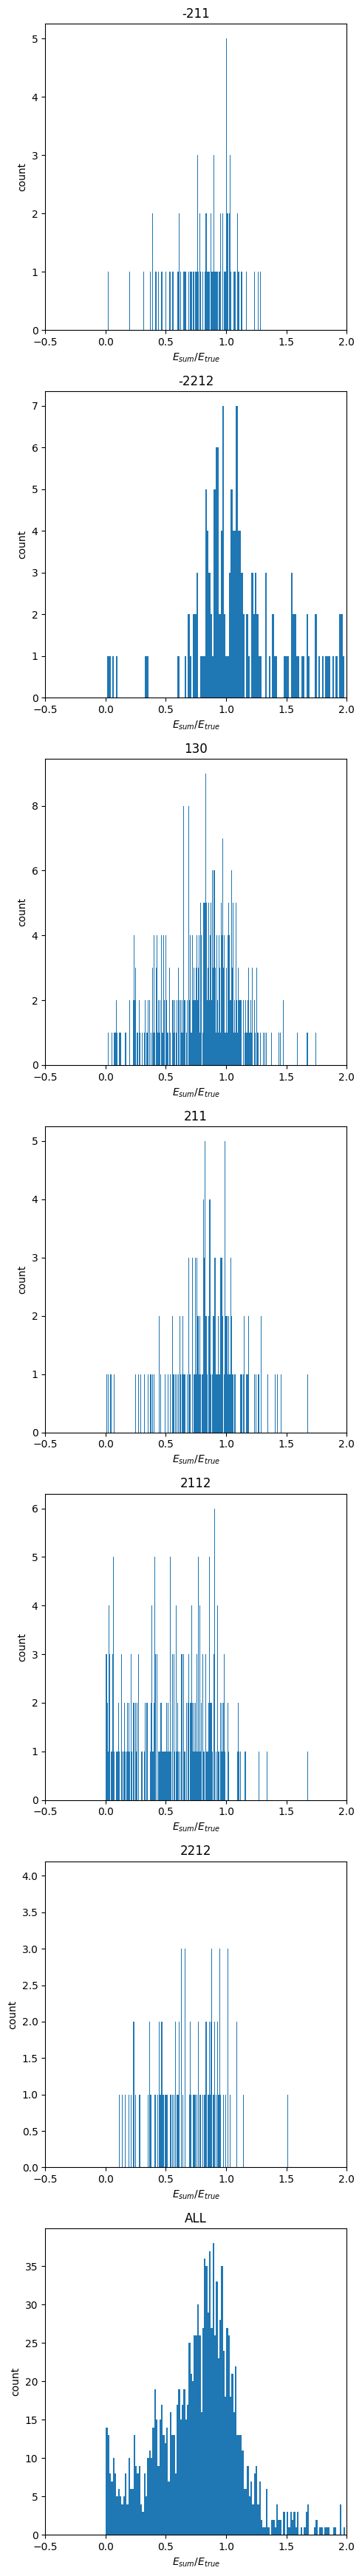

In [7]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 35))

for i in range(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400)
    ax[i].set_xlim(-0.5, 2)
    ax[i].set_ylabel("count")
    ax[i].set_xlabel(r"$E_{sum}/E_{true}$")
    ax[i].set_title(f"{keys[i]}")

fig.tight_layout()

fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/new_dataset/energy_hist_corr1.pdf")
fig.show()

In [8]:
import pickle
pickle.dump(all_ratios, open("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/corr_ds/PID_filtered_energy_sum_vs_true.pkl", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: '/eos/home-g/gkrzmanc/PF_reports/initial_histograms/corr_ds/PID_filtered_energy_sum_vs_true.pkl'